# Report: Weekly patterns in electricity and Gas Usage
Responsible for this report: Myriana Miltiadous (s3699463), Pelagia Kalpakidou (s3744825)

# Report's Question

This report is about finding any possible weekly patterns regarding electricity and Gas usage.\
So the general question is: 'Are there weekly patterns in the electricity and gas usage in 2023?' 

## Get Data through class

We created a class named HomeMessagesDB  from which we communicate with the database.\
The data of the database should be inserted in it via the command Prompt(cmd) before executing the following code in this notebook.\
All the scripts(home_messages_db,p1e.py,p1g.py) and folders with data files(P1e,P1g) should be the same directory.\
Type in cmd: ''' cd directory/of/the/scripts ''' \
Then type to insert all data from the P1e folder : ''' python p1e.py -d sqlite:///myhome.db P1e-*.csv.gz ''' \
Then type to insert all data from the P1g folder : ''' python p1g.py -d sqlite:///myhome.db P1g-*.csv.gz '''

Then you can continue with executing the following code windows and go through the report

## Import Libraries and create instance of class

In [208]:
from home_messages_db import HomeMessagesDB
import datetime
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sb
import pandas as pd
from sklearn.linear_model import LinearRegression

db_instance = HomeMessagesDB(dbfilename = "sqlite:///myhome.db") #initialize class

## Pass query to the instance of the class to read the data from the database

In [209]:
p1g_data=db_instance.db_pass_querry("SELECT * FROM p1g ORDER BY EpochId")
p1e_data=db_instance.db_pass_querry("SELECT * FROM p1e ORDER BY EpochId")

duplicatesG = p1g_data.duplicated()
num_duplicatesG = duplicatesG.sum()
print(f"Number of duplicates found in p1g and deleted: {num_duplicatesG}")
# Remove duplicates
p1g_data.drop_duplicates(inplace=True)

duplicatesE = p1e_data.duplicated()
num_duplicatesE = duplicatesE.sum()
print(f"Number of duplicates found in p1e and deleted: {num_duplicatesE}")
# Remove duplicates
p1e_data.drop_duplicates(inplace=True)

p1e_data.iloc[:,0]= [datetime.datetime.fromtimestamp(x) for x in p1e_data.iloc[:,0]]
p1g_data.iloc[:,0]= [datetime.datetime.fromtimestamp(x) for x in p1g_data.iloc[:,0]]

Number of duplicates found in p1g and deleted: 0
Number of duplicates found in p1e and deleted: 0


So, indeed no duplicates as expected since we made sure that the tables of the database are without duplicates!

# Visualizations

In this part of the report we will visualize the data from the P1e table of the database myhome.db connecting them with the report's question

## P1e: electricity Usage

To enable the required visualization, we first performed data manipulation and added extra columns.
The goal is to determine if any clear patterns appear on different days of the week.
In order to improve our ability to derive meaningful conclusions about the patterns, we also included the matching month information in the plots.
Since we have columns regarding electricity usage in low-cost and high-cost hours we added a column for the sum of those two and make our conclusions about that total.
We also added a column with Year: Week, where Year is the year and Week is the number of the week of that Year.
Finally, we added a column named 'Month' with numbers referring to months and a column named 'MonthName' with the names of the months.
Then we computed the mean usage of total electricity for every week according to measurements we have(usually evry 15 minutes) and visualize it with colors that represent the months.

### Manipulation of P1e Data

In [210]:
#add column for sum electricity usage
p1e_data['Totalelectricity']=p1e_data['T1']+p1e_data['T2']
#add a column indicating week of year and year
p1e_data['Year:Week']=[str(x.isocalendar()[0])+':'+str(x.isocalendar()[1]) for x in p1e_data['EpochId']]

#add a column for month
p1e_data['Month']=[x.month for x in p1e_data['EpochId']]
#add month name
p1e_data['MonthName'] = p1e_data['Month'].replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',11: 'November', 12: 'December'})
#check how many entries for each week
p1e_data['Year:Week'].value_counts()

#mean usage for every weeks entry--> we can not use sum because we do not have equal amount of entries for all the weeks
p1e_plot=p1e_data.drop(['MonthName'], axis=1).groupby('Year:Week').mean(numeric_only=False)
#make column month integer
p1e_plot['Month']=[x.month for x in p1e_plot['EpochId']]
#add month name
p1e_plot['MonthName'] = p1e_plot['Month'].replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',11: 'November', 12: 'December'})
p1e_plot=p1e_plot.reset_index()[['Year:Week','Totalelectricity','MonthName']]

p1e_plot[['Year', 'Week']] = p1e_plot['Year:Week'].str.split(':', expand=True)
# Convert 'Year' and 'Week' columns to numeric values
p1e_plot['Year'] = pd.to_numeric(p1e_plot['Year'])
p1e_plot['Week'] = pd.to_numeric(p1e_plot['Week'])
# Sort the DataFrame based on 'Year' and 'Week' columns
p1e_plot = p1e_plot.sort_values(['Year', 'Week'])
# Reset the index of the DataFrame
p1e_plot= p1e_plot.reset_index()[['Year:Week','Totalelectricity','MonthName']]

Since the total electricity column just keeps adding the electricity we calculated the differences

In [211]:
p1e_plot=p1e_plot.set_index(['Year:Week', 'MonthName']).diff()

## Data Overview - P1e:

The dataset consists of the following columns:

- EpochId: Unique identifier for each data entry
- SourceId: Number indicating the source file
- T1: Total electricity usage \[kWh\] in low-cost hours 
- T2: Total electricity usage \[kWh\] in high-cost hours
- Totalelectricity: Sum of T1 and T2, representing the electricity usage
- Year:Week: The year and the number of week of the measurement 
- Month: Month of meausurement (e.d 1,2,...,12)
- MonthName: Name of month of the measurment

### P1e Visualization 1 

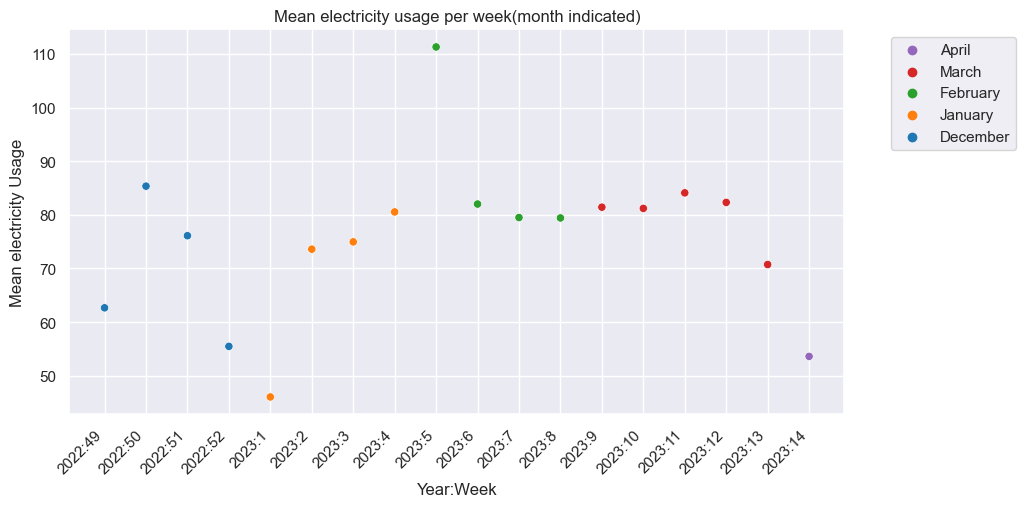

In [212]:
#plot the mean electricity usage per week
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Mean electricity usage per week(month indicated)")
sb.scatterplot(p1e_plot, x='Year:Week', y='Totalelectricity',hue='MonthName', ax=ax,palette='tab10')
plt.xticks(rotation=45, ha='right')
ax.set_ylabel('Mean electricity Usage')
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [4,3,2,1,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Comments on P1e Visualization 1 

From the above plot, we can see that from week 49 of the year 2022 until week 14 of the year 2023 the mean electricity usage has some flactuations. We can easily observe that the biggest electricity usage occurs in February and the lowest in January. However, this does not give us the whole picture of the fluctuations. Starting from December the mean electricity usage experience a rapid decrease untill January's first week. Then again a big increase in the second week of january. From that week and before March's last week the mean electricity usage stabilize and then experience a big decrease in April. Those results make sense since in general the electricity used in winter is bigger due to the cold.

### P1e Visualization 2

In [213]:
p1e_data['Day']=p1e_data['EpochId'].dt.dayofweek
#name the days of week
p1e_data['Day'] = p1e_data['Day'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday',5: 'Saturday', 6: 'Sunday'})
p1e_data['Day'] = pd.Categorical(p1e_data['Day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
#plot the electricity usage per day of week for all weeks with lines for each month

Since the total electricity column just keeps adding the electricity we calculated the differences

In [214]:
p1e_data=p1e_data.drop(['T1','T2'], axis=1)
p1e_data=p1e_data.set_index(['EpochId','SourceId','Year:Week','Month','MonthName','Day']).diff()

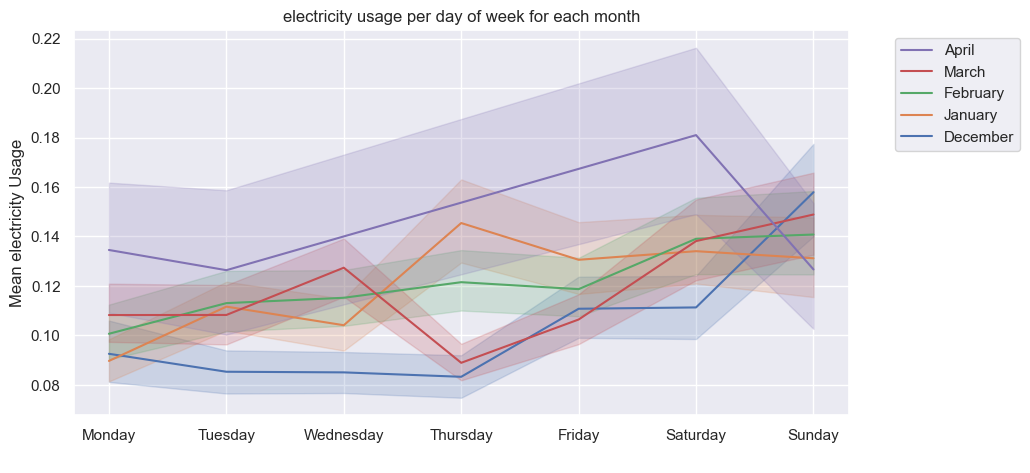

In [215]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("electricity usage per day of week for each month")
tab10=sb.color_palette("tab10")
tab10[0],tab10[1],tab10[2],tab10[3],tab10[4]=tab10[3],tab10[2],tab10[4],tab10[1],tab10[0]
sb.lineplot(p1e_data, x='Day', y='Totalelectricity', hue='MonthName', ax=ax, palette=tab10[0:5].reverse())
# sb.scatterplot(p1e_data, x='Day', y='Totalelectricity', hue='MonthName', ax=ax, palette=tab10[0:5].reverse())
ax.set_xlabel(' ')
ax.set_ylabel('Mean electricity Usage')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [4,3,2,1,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Comments on P1e Visualization 2

From the above plot, we can see that within same months, there are fluctuations of the mean electricity usage electricity occurs across the different days of the week. It is obvious from that plot, that in December almost all Daily usage electricity are less than the other months. On the other hand, April has the biggest daily mean consumption electricity. This is strange according to our previously mentioned points but it might be due to the very few observations that we have for April.
The additional observations that we can make using these plots are regarding the patterns between the days of the week. For example, we can see that for different months the biggest mean electricity usage occurs in different days. For December, February and March it is Sunday, for January it is Thursday and for April Saturday. So, a general conclution which make sense is that in the weekends there is bigger usage electricity than in the other days, possibly since more people are in the house because of no work or school. Moreover for all the months except April and December the least consumption seems to occur in Monday. A final important comment is that the least flactuations among the different days are observed in February, possibly because the people in the house have more similar schedules across the days of the week.

## P1g: Gas Usage

We performed the same kind of visualizations with Gas data from the P1g table of the database as we deed with the data from the P1e table again to comment on the weekly patterns. Again we performed similar modifications to the data as before.

### Manipulation of P1g Data 

In [216]:
#add a column indicating week of year and year
p1g_data['Year:Week']=[str(x.isocalendar()[0])+':'+str(x.isocalendar()[1]) for x in p1g_data['EpochId']]
#add a column for month
p1g_data['Month']=[x.month for x in p1g_data['EpochId']]
#add month name
p1g_data['MonthName'] = p1g_data['Month'].replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',11: 'November', 12: 'December'})
#check how many entries for each week
p1g_data['Year:Week'].value_counts()

#mean usage for every weeks entry--> we can not use sum because we do not have equal amount of entries for all the weeks
p1g_plot=p1g_data.drop(['MonthName'], axis=1).groupby('Year:Week').mean(numeric_only=False)
#make column month integer
p1g_plot['Month']=[x.month for x in p1g_plot['EpochId']]
#add month name
p1g_plot['MonthName'] = p1g_plot['Month'].replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',11: 'November', 12: 'December'})
p1g_plot=p1g_plot.reset_index()[['Year:Week','TotalGas','MonthName']]

p1g_plot[['Year', 'Week']] = p1g_plot['Year:Week'].str.split(':', expand=True)
# Convert 'Year' and 'Week' columns to numeric values
p1g_plot['Year'] = pd.to_numeric(p1g_plot['Year'])
p1g_plot['Week'] = pd.to_numeric(p1g_plot['Week'])
# Sort the DataFrame based on 'Year' and 'Week' columns
p1g_plot = p1g_plot.sort_values(['Year', 'Week'])
# Reset the index of the DataFrame
p1g_plot= p1g_plot.reset_index()[['Year:Week','TotalGas','MonthName']]

Since the total electricity column just keeps adding electricity we calculated the differences

In [217]:
p1g_plot=p1g_plot.set_index(['Year:Week', 'MonthName']).diff()

## Data Overview - P1g:

The dataset consists of the following columns:

- Year:Week: The year and the number of week of the measurement
- TotalGas: Total gas usage
- MonthName: Name of month of the measurment

### P1g Visualization 1 

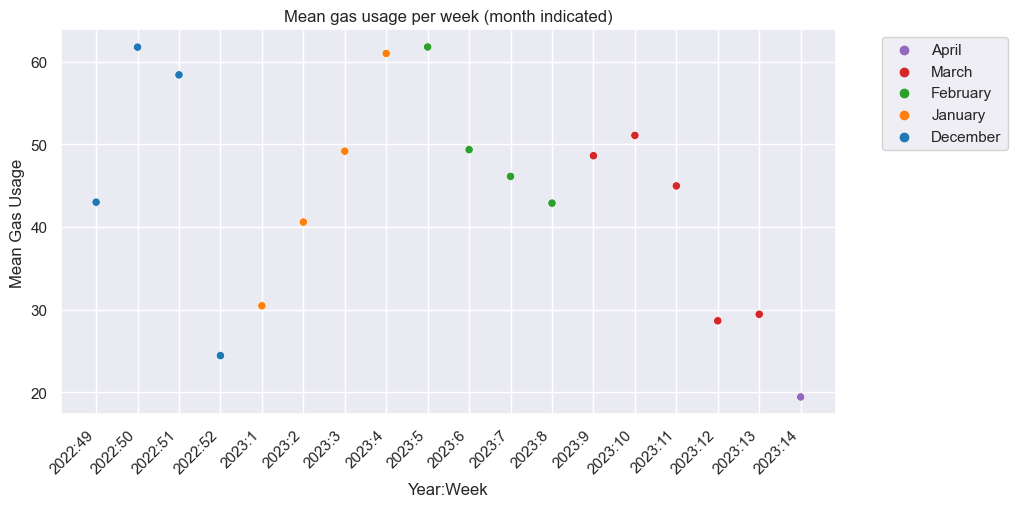

In [218]:
#plot the mean gas usage per week
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Mean gas usage per week (month indicated)")
sb.scatterplot(p1g_plot, x='Year:Week', y='TotalGas',hue='MonthName', ax=ax,palette='tab10')
plt.xticks(rotation=45, ha='right')
ax.set_ylabel('Mean Gas Usage')
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [4,3,2,1,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Comments on P1g visualization 1

According to the presented graph, there are many fluctuations in the mean gas usage from week 49 of the year 2022 to week 14 of the year 2023. It is clear that April has the lowest gas use, whereas the winter months have the highest. This, however, does not provide us with a complete picture of the variations. Beginning in December and continuing through the first week of January, the average gas usage increase and decrease rapidly without having any obvious pattern. From the first week of January until the first week of Feruaryy the mean gas usage keeps increasing. That might be due to more cold days that resulted in more heating in the house to be needed. After that, when the plot reaches its maximum the mean gas usage keeps decreasing steadily except for the 9th and 10th week of 2023, where it experienced a small increase. Then it drops signifficantly until April where it reaches its minimum. These findings also make sense given that winter requires more gas overall owing to the cold.

###  P1g Visualization 2

In [219]:
p1g_data['Day']=p1g_data['EpochId'].dt.dayofweek
#name the dyas of week
p1g_data['Day'] = p1g_data['Day'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday',5: 'Saturday', 6: 'Sunday'})
p1g_data['Day'] = pd.Categorical(p1g_data['Day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

Since the total electricity column just keeps adding electricity we calculated the differences

In [220]:
p1g_data=p1g_data.set_index(['EpochId','SourceId','Year:Week','Month','MonthName','Day']).diff()
p1g_data=p1g_data.reset_index()

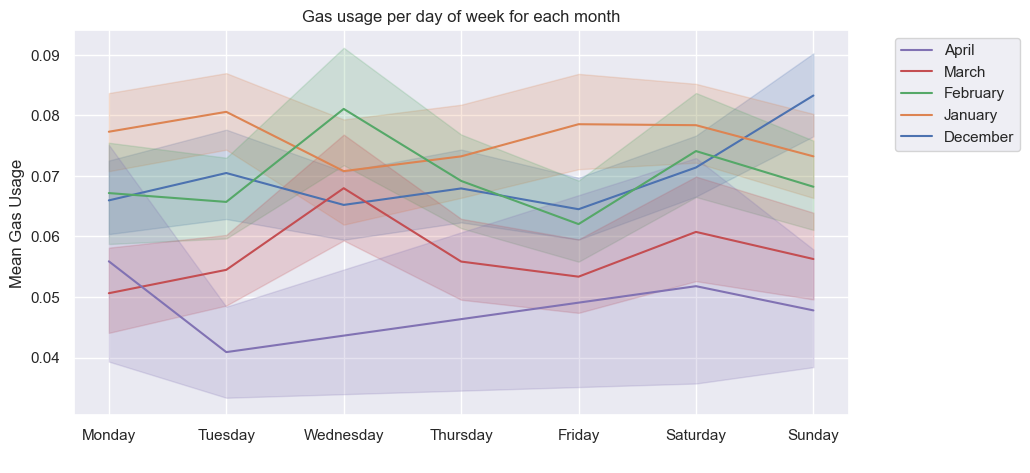

In [221]:
#plot the gas usage per day of week for all weeks with lines for each month
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Gas usage per day of week for each month")
tab10=sb.color_palette("tab10")
tab10[0],tab10[1],tab10[2],tab10[3],tab10[4]=tab10[3],tab10[2],tab10[4],tab10[1],tab10[0]
sb.lineplot(p1g_data, x='Day', y='TotalGas', hue='MonthName',ax=ax, palette=tab10[0:5].reverse())
#sb.scatterplot(p1g_data, x='Day', y='TotalGas', hue='MonthName', ax=ax, palette=tab10[0:5].reverse())
ax.set_ylabel('Mean Gas Usage')
ax.set_xlabel(' ')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [4,3,2,1,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Comments on P1g Visualization 2

We can observe from the following plot that there are variations in the mean gas usage throughout the various days of the week within the same months. The graphic makes it clear that compared to the other months, practically all daily gas usage is lower in April. Contrary, January has the higher daily mean gas used compared to almost all months. These plots also allow us to make further observations about the relationships between the days of the week. For instance, we can observe that the largest mean gas use for various months happens on various days. Particularly the highest mean gas usage occurs Sunday for December, in Tuesday for January, in Monday for April and in Wendnesday for March and February . Therefore, a general conclusion that makes sense is that gas usage on winter months is higher than on other months  for all the days of the week. Relatively high usage is occure at the weekends which again make sense. However this time we also have very high values for other days of the week. Additionally, for almost every month Monday or/and Tuesday tend to be the days with the lowest consumption. Another significant observation is that January is the month with the fewest fluctuations among the different days, probably as a result of the residents' more consistent weekly gas schedules.

# Tables

In this part of the report, some tables regarding electricity and gas will be discussed. Specifically, we created the summary statistics for the mean of all measurements total gas and total electricity usage for all the different months that we have information about and for the different days of the week. That way we can examine further the patterns and have specific numbers in addition to the previously discussed visualizations.

## P1G: Gas Usage

### P1G TABLE 1(Months)

As already observed from visualizations before, the highest mean usage of gas occurs in January and the lowest one in April, as well as all the other 3 quantiles in the table. The highest gas usage measurement (gas is measured every 15 minutes mos of the times) was in March and the lowest in December. The least amount of gas used is 0.0, which make sense since there should be timeslots without gas usage.The Standard deviation is the smallest in April and the largest in December. This is because in April we do not have as much data as for the other months. Finally, as evidenced by their higher standard deviations, January, February and March exhibit more notable swings in gas use.

In [222]:
p1g_data.groupby('MonthName').describe()['TotalGas']
p1g_data.groupby('MonthName').describe()['TotalGas'].round(2).sort_values(by='mean', ascending=False)


,count,mean,std,min,25%,50%,75%,max
MonthName,,,,,,,,
January,2977.0,0.08,0.08,0.0,0.03,0.06,0.09,0.71
December,2975.0,0.07,0.06,0.0,0.03,0.06,0.09,0.60
February,2689.0,0.07,0.08,0.0,0.03,0.06,0.08,0.71
March,2972.0,0.06,0.08,0.0,0.02,0.04,0.07,0.95
April,379.0,0.05,0.07,0.0,0.01,0.03,0.06,0.65


### P1G TABLE 2(Days)

Interesting information about the consumption trends based on different days of the week without taking into account the month may be found in the gas following table. The figure show that the average daily gas consumption is about 0.07, on average, over all days. With a mean of 0.07, the standard deviation shows that gas use is generally stable, indicating that day-to-day variations in usage are minimal. The least amount of gas used was again 0.0, which make sense since as already mentioned, there should be timeslots without gas usage. and the largest amounts ranged from 0.67 to 0.95. The 25th and 75th percentiles also shed light on the distribution of gas consumption. Most days fall between 0.02 and 0.08, with a few outliers reaching higher values as high as 0.95. Overall, the data point to a pattern of gas usage that is very steady and consistent throughout the course of the week.

In [223]:
p1g_data.groupby('Day').describe()['TotalGas']
p1g_data.groupby('Day').describe()['TotalGas'].round(2).sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Day,,,,,,,,
Monday,1728.0,0.07,0.07,0.0,0.02,0.05,0.08,0.95
Tuesday,1725.0,0.07,0.07,0.0,0.03,0.05,0.08,0.68
Wednesday,1632.0,0.07,0.09,0.0,0.02,0.05,0.08,0.71
Thursday,1727.0,0.07,0.07,0.0,0.02,0.05,0.08,0.82
Saturday,1728.0,0.07,0.07,0.0,0.03,0.06,0.09,0.68
Sunday,1724.0,0.07,0.07,0.0,0.02,0.06,0.09,0.71
Friday,1728.0,0.06,0.07,0.0,0.02,0.05,0.08,0.67


## P1E: electricity Usage

### P1E TABLE 1(Months)

We can see from the data analysis that the average electricity consumption for all months ranges from 0.10 to 0.14. With values ranging from 0.13 to 0.14, the standard deviation suggests some fluctuations in electricity usage that the usage patterns vary significantly between months. The least and largest electricity used were respectively 0.00 and 0.03, and 0.82 and 1.43. The distribution of electricity consuption may be seen from the 25th and 75th percentiles, which show that most months lie between 0.04 and 0.13. There are a few outliers with greater numbers, up to 1.43, though.
Overall, the data indicates that there are seasonal variations in the use of electricity , with higher use during particular times of the year. The highest mean is for April and the lowest for December. The range and distribution electricity usage are shown by the standard deviation and percentile values, which can be used to analyze and manage yearly  electricity consumption.

In [224]:
p1e_data.groupby('MonthName').describe()['Totalelectricity']
p1e_data.groupby('MonthName').describe()['Totalelectricity'].round(2).sort_values(by='mean', ascending=False)


,count,mean,std,min,25%,50%,75%,max
MonthName,,,,,,,,
April,375.0,0.14,0.14,0.03,0.05,0.08,0.19,0.82
February,2688.0,0.12,0.13,0.00,0.04,0.07,0.14,1.09
January,2976.0,0.12,0.14,0.01,0.04,0.07,0.13,1.34
March,2972.0,0.12,0.13,0.02,0.05,0.06,0.12,1.43
December,2975.0,0.10,0.13,0.01,0.03,0.05,0.11,1.25


### P1E TABLE 2(Days)

Analyzing the data reveals that the daily average electricity consumption ranges from 0.10 to 0.14. With values ranging from 0.11 to 0.17, the standard deviation shows some variation in electricity consumption, indicating that usage patterns vary slightly depending on the day of the week.
The minimum and largest amounts of electricity used were respectively 0.00 and 0.02, and 1.00 and 1.43. The distribution of electricity use may be seen from the 25th and 75th percentiles, which show that most days lie between 0.04 and 0.12. There are a few outliers with greater numbers, up to 1.43, though.
Overall, the data indicates that different days of the week experience different levels of electricity consumption, with some days, like the weekends showing more consumption than others. The range and distribution of electricity usage are shown by the standard deviation and percentile values, which can be used to analyze and manage weekly patterns in electricity consumption.

In [225]:
p1e_data.groupby('Day').describe()['Totalelectricity']
p1e_data.groupby('Day').describe()['Totalelectricity'].round(2).sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Day,,,,,,,,
Sunday,1724.0,0.14,0.17,0.00,0.04,0.07,0.16,1.34
Saturday,1728.0,0.13,0.15,0.02,0.04,0.07,0.15,1.43
Friday,1728.0,0.12,0.13,0.02,0.04,0.07,0.12,1.08
Tuesday,1719.0,0.11,0.11,0.02,0.04,0.06,0.12,1.00
Wednesday,1632.0,0.11,0.12,0.02,0.04,0.07,0.12,0.92
Thursday,1727.0,0.11,0.12,0.01,0.04,0.06,0.12,1.06
Monday,1728.0,0.10,0.11,0.01,0.04,0.06,0.11,1.25


# Conclusion

In conclusion, the data analysis gives critical information about trends in gas and electricity usage.

It becomes clear by looking at electricity use that different days of the week have different levels of electricity demand. Consumption is generally higher on weekends than it is on other days. The standard deviation shows minor differences in electricity consumption patterns, highlighting the importance of taking daily variations into account.It becomes clear that there are seasonal changes in electricity use when taking into account electricity consumption over several months. Electricity use varies by month, with April having the highest mean and December having the lowest. The standard deviation highlights the necessity for a thorough understanding of yearly electricity consumption patterns by indicating swings in electricity use between months.

The research shows a rather stable and regular usage pattern throughout the week when focusing on gas consumption. The standard deviation shows that there aren't many daily differences in gas use, emphasizing how consistent gas consumption is. With a few outliers reaching greater numbers, the majority of days fall between 0.02 and 0.08 in value.The largest mean monthly gas consumption is seen in January, while the lowest is seen in April. The data also reveals that the highest gas usage timeslot-measurement was in March, while the lowest was in December. Additionally, due to variations in the data that are available, the standard deviation is smaller in April and larger in December. Notably, as evidenced by their higher standard deviations, January, February, and March show more noticeable variations in gas usage.

Overall, the analyses' conclusions offer useful information for comprehending and controlling patterns of gas and electricity consumption. Stakeholders can improve energy use and create effective consumption strategies by taking into account daily, weekly, monthly, and yearly variations.